In [47]:
import torch
import math
import pandas as pd
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchvision.transforms import transforms
from math import sqrt
from torchvision.ops import nms,roi_pool
from tqdm.auto import tqdm

In [ ]:
file_dir = r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\pascalvoc-yolo\100examples.csv"
df = pd.read_csv(file_dir)

image    000026.jpg
text     000026.txt
Name: 1, dtype: object

In [19]:
class VOC_dataset(Dataset):
    def __init__(self, file_dir, img_dir, label_dir, img_size, transforms= None):
        self.annotations = pd.read_csv(file_dir)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.transforms = transforms

    def __getitem__(self, idx):
        img = Image.open(path.join(self.img_dir, self.annotations.iloc[idx, 0]))

        if (self.transforms):
            img = self.transforms(img)
        
        labels_path = path.join(self.label_dir, self.annotations.iloc[idx, 1])
        file_ref = open(labels_path, "r")
        final = []
        for lst in file_ref.readlines():
            example = []
            for label in lst.strip().split(" "):
                example.append(float(label))
            example = [int(example[0])] + [item * self.img_size for item in example[1:]]
            final.append(example)
        
        return img, final
    def __len__(self):
        return len(self.annotations)

In [20]:
def my_collate(batch):
    # batch - Một danh sách các tuple đại diện cho (images, bboxes)

    # Chồng các ảnh thành một tensor
    images = torch.stack([item[0] for item in batch])

    # Tách các nhãn bbox
    bboxes = [item[1] for item in batch]

    # Trả về một danh sách gồm tensor ảnh và danh sách các nhãn bbox tương ứng
    return [images, bboxes]


In [21]:
settings = {
    "img_size": 800,
    "pre_nms_top_n": 12000,
    "nms_threshold": 0.7,
    "post_nms_top_n": 2000,
    "pos_threshold": 0.7,
    "neg_threshold": 0.3,
    "num_RPN_samples": 256,
    "fg_threshold": 0.5,
    "bg_threshold_hi": 0.5,
    "bg_threshold_lo": 0.1,
    "num_classification_samples": 1000,  # Thay đổi
    "pool_size": 7,
    "ss_ratio": 16,
    "num_classes": 20,
    "feature_map_height": 50,
    "feature_map_width": 50,
    "feature_map_depth": 512,
    "anchor_ratios": [0.5, 1, 2],
    "anchor_scales": [8, 16, 32],
    "beta_rpn_loss": 1,  # Thay đổi
    "lambd_rpn_loss": 1,  # Thay đổi
    "beta_classifier_loss": 1,  # Thay đổi
    "lambd_classifier_loss": 1,  # Thay đổi
    "lr": 0.001  # Thay đổi
}

In [ ]:
batch_size = 1
mean_list = [0.485, 0.456, 0.406]
std_list = [0.229, 0.224, 0.225]

# Tạo một chuỗi biến đổi để chuẩn hóa và thay đổi kích thước ảnh
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list, std_list),
    transforms.Resize((settings["img_size"], settings["img_size"]))
])

# Tạo đối tượng của lớp VOC_dataset để đọc và xử lý dữ liệu
train_set = VOC_dataset(r".\pascalvoc-yolo\train.csv",
                        r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\pascalvoc-yolo\images",
                        r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\pascalvoc-yolo\labels",
												settings["img_size"],transform)

test_set = VOC_dataset(r".\pascalvoc-yolo\test.csv",
                        r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\pascalvoc-yolo\images",
                        r"D:\Studying\Personal_Project\Computer Vision\PascalVOC YOLO\pascalvoc-yolo\labels",
												settings["img_size"],transform)

# Sử dụng DataLoader để tạo các batch dữ liệu từ tập dữ liệu
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, collate_fn=my_collate)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=my_collate)

In [ ]:
def plot_image(image, bboxes, mean_tensor, std_tensor, classes):
    # Chuẩn hóa ảnh trước khi hiển thị để tránh hiển thị ảnh không chính xác
    image = image * std_tensor + mean_tensor
    np_image = np.transpose(np.array(image), (1, 2, 0))
    
    plt.imshow(np_image)
    ax = plt.gca()

    for bbox in bboxes:
        x_center, y_center, width, height = bbox[1], bbox[2], bbox[3], bbox[4]
        x_tl, y_tl = (x_center - width/2), (y_center - height/2)

        # Thêm hình chữ nhật vào đồ thị với thông tin bbox
        ax.add_patch(matplotlib.patches.Rectangle((x_tl, y_tl), width, height, linewidth=1, edgecolor='r', facecolor='none'))

        # Hiển thị nhãn lớp bên trong hình chữ nhật
        plt.text(x_tl, y_tl, classes[int(bbox[0])], backgroundcolor='r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


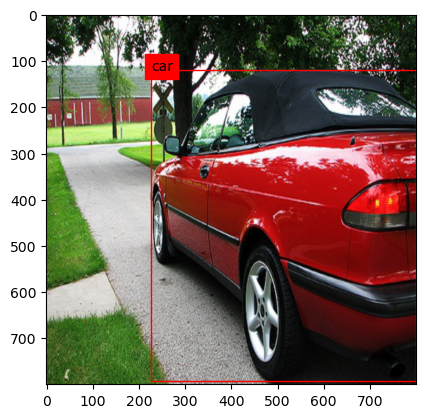

In [46]:
mean_tensor = torch.tensor(mean_list).view(-1, 1, 1)
std_tensor = torch.tensor(std_list).view(-1, 1, 1)

# Số lớp đúng
num_classes = 21  # Đã cập nhật để bao gồm lớp 'background'
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
           'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person',
           'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor',
           'background')

idx = 0
# Chọn một ví dụ từ train_loader
try:
    example = next(iter(train_loader))
    if idx < 0 or idx >= len(example[0]):
        raise IndexError("Chỉ số 'idx' vượt quá giới hạn")

    image = example[0][idx]  # Ảnh tại chỉ số idx
    bboxes = example[1][idx]  # Bounding box tại chỉ số idx

    # Vẽ đồ thị ảnh với bounding box
    plot_image(image, bboxes, mean_tensor, std_tensor, classes)
except StopIteration:
    print("train_loader không có dữ liệu.")
except IndexError as e:
    print(e)

In [48]:
def anchors_location(x, y, anchor_ratios, anchor_scales, ss_ratio):
    """
    Tính toán anchor box dựa theo (x, y) trên bản đồ đặc trưng, tỷ lệ quy mô của anchor box
    Inputs:
        x, y - Tọa độ từ bản đồ đặc trưng.
        anchor_ratios - Danh sách các tỷ lệ chiều cao/chiều rộng.
        anchor_scales - Danh sách tỷ lệ quy mô.
        ss_ratio - Tỷ lệ lấy mẫu dưới.
    Ouput: 
        anchor - len(anchor_scales) * len(anchor_ratios) x 4
    """
    num_ratios = len(anchor_ratios)
    s = ss_ratio // 2
    x_ctr = (2*x + 1) * s
    y_ctr = (2*y + 1) * s
    anchors = []

    for ratio_idx, ratio in enumerate(anchor_ratios):
        for scale_idx, scale in enumerate(anchor_scales):
            current = num_ratios * ratio_idx + scale_idx
            h = ss_ratio * scale * math.sqrt(ratio)
            w = ss_ratio * scale * math.sqrt(1 / ratio)
            anchors.append([x_ctr, y_ctr, w, h])

    return torch.tensor(anchors)

In [ ]:
def anchor_generation(h, w, device, anchor_ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32], ss_ratio=16):
    '''
    Tạo ra các anchor box tại từng tọa độ trên bản đồ đặc trưng.

    Inputs:
        h, w - Chiều cao và chiều rộng của bản đồ đặc trưng
        anchor_ratios - Danh sách các tỉ lệ chiều cao/chiều rộng của anchor
        anchor_scales - Danh sách các quy mô của anchor
        ss_ratio - Tỷ lệ lấy mẫu dưới, cho VGG16 thì là 16
    Output:
        anchors - Một tensor có kích thước (h*w*num_anchors x 4),
            trong đó num_anchors = len(anchor_ratios) * len(anchor_scales)
    '''
    # Khởi tạo tensor anchors với kích thước phù hợp
    anchors = torch.zeros((h, w, len(anchor_ratios) * len(anchor_scales), 4))

    # Duyệt qua từng tọa độ trên bản đồ đặc trưng để tính toán anchors
    for y in range(h):
        for x in range(w):
            # Tính toán anchors cho từng tọa độ
            anchors[y, x] = anchors_location(x, y, anchor_ratios, anchor_scales, ss_ratio)

    # Reshape tensor anchors để có kích thước (h*w*num_anchors x 4) và chuyển sang device
    return anchors.reshape(-1, 4).to(device)


In [5]:
def convert_to_center(proposals):
    x_tl = proposals[:, 0]
    y_tl = proposals[:, 1]
    x_br = proposals[:, 2]
    y_br = proposals[:, 3]

    x_ctr = (x_tl + x_br)/2
    y_ctr = (y_tl + y_br)/2

    w = (x_br - x_tl).unsqueeze(-1)
    h = (y_br - y_tl).unsqueeze(-1)

    return torch.cat([x_ctr, y_ctr, w, h], axis= 1)

In [4]:
def get_iou_matrix(anchors, gt_bboxes, device):
    a_x1 = anchors[:, 0]
    a_y1 = anchors[:, 1]
    a_x2 = anchors[:, 2]
    a_y2 = anchors[:, 3]

    iou_matrix = torch.zeros((anchors.shape[0], len(gt_bboxes)), device= device)
    zero_tensor = torch.tensor([0], device= device)

    for gt_idx, gt_box in enumerate(gt_bboxes):
        _, gt_x_ctr, gt_y_ctr, gt_w, gt_h = gt_box
        gt_x1 = torch.tensor(gt_x_ctr - gt_w/2, device= device)
        gt_y1 = torch.tensor(gt_y_ctr - gt_h/2, device= device)
        gt_x2 = gt_x1 + gt_w
        gt_y2 = gt_y1 + gt_h

        x1 = torch.maximum(a_x1, gt_x1)
        x2 = torch.maximum(a_y1, gt_y1)
        y1 = torch.minimum(a_x2, gt_x2)
        y2 = torch.minimum(a_y2, gt_y2)

        intersection = torch.maximum(zero_tensor, (x2-x1)) * torch.maximum(zero_tensor, (y2-y1))
        union = (a_x2-a_x1) * (a_y2-a_y1) + (gt_x2-gt_x1) * (gt_y2-gt_y1) - intersection
        iou_matrix[:, gt_idx] = intersection / (union + 1e-8)

        return iou_matrix

In [6]:
class Classifier(nn.Module):
    def __init__(self, in_channels, pool_size, num_classes):
        super().__init__(Classifier, self)
        
        self.flat = in_channels*pool_size*num_classes
        self.fc1 = nn.Linear(
            in_features= self.flat, out_features= 4096
            )
        self.fc2 = nn.Linear(
            in_features= 4096, out_features= 4096
            )
        self.relu =nn.ReLU()
        self.score_layer = nn.Linear(
            in_features= 4096, out_features= num_classes + 1 
        )
        self.offset_layer = nn.Linear(
            in_features= 4096, out_features= 4* num_classes
        )
    
    def forward(self, x):
        x = x.view(-1, self.flat)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        class_score = self.score_layer(x)
        offsets = self.offset_layer(x)
        
        return class_score, offsets

In [ ]:
class RPN_Loss(nn.Module):
    def __init__(self, beta, lambd, device):
        super(RPN_Loss).__init__()
        
        self.lambd = lambd
        self.smooth_l1 = nn.SmoothL1Loss(beta=beta)
        self.BCELoss = nn.BCELoss()
        self.device = device
    
    def forward(self, foreground_samples, background_samples):
        
        foreground_scores = torch.ones(foreground_samples.shape[0], device= self.device)
        background_scores = torch.ones(background_samples.shape[0], device= self.device)

        gt_scores = torch.cat([foreground_scores, background_scores], axis= 0)
        
        pred_scores = torch.cat([foreground_samples[:, 1].view(-1), background_samples[:, 1].view(-1)], axis= 0)

        loss_cls = self.BCELoss(pred_scores, gt_scores)
        loss_coords = self.smooth_l1(foreground_samples[:,2:6], background_samples[:, 2:6])

        return loss_cls + self.lambd * loss_coords